# Retail Forecasting Project

In [7]:
'''This notebook presents a machine learning-based retail sales forecasting approach using a combination of classical 
statistical methods and modern ensemble models, including ARIMA, SARIMA, and ARIMAX.'''

'This notebook presents a machine learning-based retail sales forecasting approach using a combination of classical \nstatistical methods and modern ensemble models, including ARIMA, SARIMA, and ARIMAX.'

## Imports and Setup

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from math import ceil
import warnings

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

## Data Loading and Preparation

In [20]:
conn = sqlite3.connect("hipermercado.db")
df_calendar = pd.read_sql("SELECT * FROM calendar", conn).drop(columns='index')
df_prices = pd.read_sql("SELECT * FROM sell_prices", conn).drop(columns='index')
df_sales = pd.read_sql("SELECT * FROM sales", conn).drop(columns='index')

## Data Transformation and Merging

In [21]:
df_sales = df_sales.melt(id_vars=df_sales.columns[0:6], var_name='d', value_name='sales')
df = df_sales.merge(df_calendar, on='d', how='left')
df = df.merge(df_prices, on=['store_id','item_id','wm_yr_wk'], how='left')
df['date'] = pd.to_datetime(df['date'])

## Filter for a Sample SKU

In [22]:
sku_df = df.copy()

## Feature Engineering

In [23]:
sku_df['dayofweek'] = sku_df['date'].dt.dayofweek
sku_df['lag_1'] = sku_df['sales'].shift(1)
sku_df['rolling_mean_7'] = sku_df['sales'].shift(1).rolling(window=7).mean()
sku_df = sku_df.dropna()

features = ['dayofweek', 'sell_price', 'lag_1', 'rolling_mean_7']

## Time-Based Train-Test Split

In [24]:
split_date = sku_df['date'].max() - pd.Timedelta(days=30)
train = sku_df[sku_df['date'] <= split_date]
valid = sku_df[sku_df['date'] > split_date]
X_train, y_train = train[features], train['sales']
X_valid, y_valid = valid[features], valid['sales']

## Model Training & Grid Search

In [43]:
def train_and_select_best_model(X_train, y_train, X_valid, y_valid):
    results = []

    models = {
        "RandomForest": {
            "model": RandomForestRegressor(),
            "params": {
                "n_estimators": [100],
                "max_depth": [10]
            }
        },
        "HistGradientBoosting": {
            "model": HistGradientBoostingRegressor(),
            "params": {
                "max_iter": [200],
                "max_depth": [10]
            }
        },
        "LGBM": {
            "model": LGBMRegressor(),
            "params": {
                "n_estimators": [200],
                "learning_rate": [0.05]
            }
        }
    }

    for name, cfg in models.items():
        min_samples = len(X_train)
        n_splits = min(3, max(2, min_samples - 1))
        tscv = TimeSeriesSplit(n_splits=n_splits)
        gscv = GridSearchCV(cfg["model"], cfg["params"], scoring="neg_mean_absolute_percentage_error", cv=tscv)
        gscv.fit(X_train, y_train)
        preds = gscv.predict(X_valid)
        mape = mean_absolute_percentage_error(y_valid, preds)
        mae = mean_absolute_error(y_valid, preds)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        results.append({"Model": name, "Estimator": gscv.best_estimator_, "MAPE": mape, "MAE": mae, "RMSE": rmse, "Params": gscv.best_params_})

#    try:
#        model_arima = ARIMA(y_train.reset_index(drop=True), order=(1,1,1)).fit()
#        preds_arima = model_arima.forecast(steps=len(y_valid))
#        results.append({"Model": "ARIMA", "Estimator": model_arima, "MAPE": mean_absolute_percentage_error(y_valid, preds_arima), "MAE": mean_absolute_error(y_valid, preds_arima), "RMSE": np.sqrt(mean_squared_error(y_valid, preds_arima)), "Params": "(1,1,1)"})
#    except:
#        pass
# --> delete this comment to activate Arima model
    try:
        model_sarima = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,7)).fit()
        preds_sarima = model_sarima.forecast(steps=len(y_valid))
        results.append({"Model": "SARIMA", "Estimator": model_sarima, "MAPE": mean_absolute_percentage_error(y_valid, preds_sarima), "MAE": mean_absolute_error(y_valid, preds_sarima), "RMSE": np.sqrt(mean_squared_error(y_valid, preds_sarima)), "Params": "(1,1,1)(1,1,1,7)"})
    except:
        pass

    try:
        model_arimax = SARIMAX(endog=y_train, exog=X_train[['sell_price']], order=(1,1,1)).fit()
        preds_arimax = model_arimax.forecast(steps=len(y_valid), exog=X_valid[['sell_price']])
        results.append({"Model": "ARIMAX", "Estimator": model_arimax, "MAPE": mean_absolute_percentage_error(y_valid, preds_arimax), "MAE": mean_absolute_error(y_valid, preds_arimax), "RMSE": np.sqrt(mean_squared_error(y_valid, preds_arimax)), "Params": "ARIMA(1,1,1) + exog: sell_price"})
    except:
        pass

    results_df = pd.DataFrame(results).sort_values(by="MAPE")
    best_row = results_df.iloc[0]
    print(f"Best model: {best_row['Model']} with MAPE: {best_row['MAPE']:.4f}")
    return results_df, best_row

results_df, best_model = train_and_select_best_model(X_train, y_train, X_valid, y_valid)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 10, number of used features: 0
[LightGBM] [Info] Start training from score 44.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

Best model: SARIMA with MAPE: 12815180118020788.0000


## Model Selection & Summary

In [44]:
results_df

,Model,Estimator,MAPE,MAE,RMSE,Params
3,SARIMA,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,1.281518e+16,42.179655,57.255066,"(1,1,1)(1,1,1,7)"
4,ARIMAX,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,1.418791e+16,29.533467,45.382112,"ARIMA(1,1,1) + exog: sell_price"
0,RandomForest,"(DecisionTreeRegressor(max_depth=10, max_featu...",2.885156e+16,23.573017,31.118630,"{'max_depth': 10, 'n_estimators': 100}"
2,LGBM,"LGBMRegressor(learning_rate=0.05, n_estimators...",3.560096e+16,30.310000,39.894180,"{'learning_rate': 0.05, 'n_estimators': 200}"
1,HistGradientBoosting,"HistGradientBoostingRegressor(max_depth=10, ma...",3.840867e+16,29.342188,40.118895,"{'max_depth': 10, 'max_iter': 200}"


In [45]:
display(results_df)

,Model,Estimator,MAPE,MAE,RMSE,Params
3,SARIMA,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,1.281518e+16,42.179655,57.255066,"(1,1,1)(1,1,1,7)"
4,ARIMAX,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,1.418791e+16,29.533467,45.382112,"ARIMA(1,1,1) + exog: sell_price"
0,RandomForest,"(DecisionTreeRegressor(max_depth=10, max_featu...",2.885156e+16,23.573017,31.118630,"{'max_depth': 10, 'n_estimators': 100}"
2,LGBM,"LGBMRegressor(learning_rate=0.05, n_estimators...",3.560096e+16,30.310000,39.894180,"{'learning_rate': 0.05, 'n_estimators': 200}"
1,HistGradientBoosting,"HistGradientBoostingRegressor(max_depth=10, ma...",3.840867e+16,29.342188,40.118895,"{'max_depth': 10, 'max_iter': 200}"


## Performance Visualization

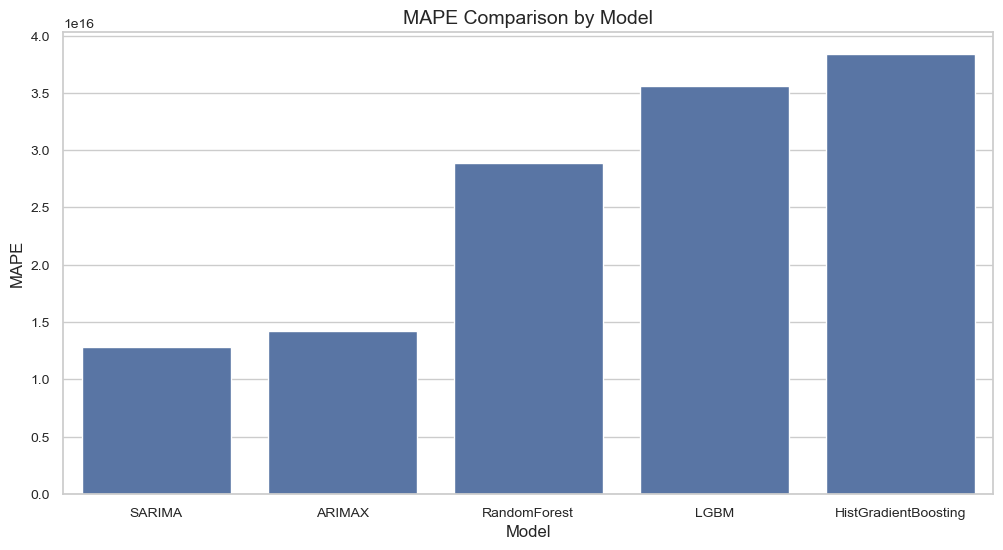

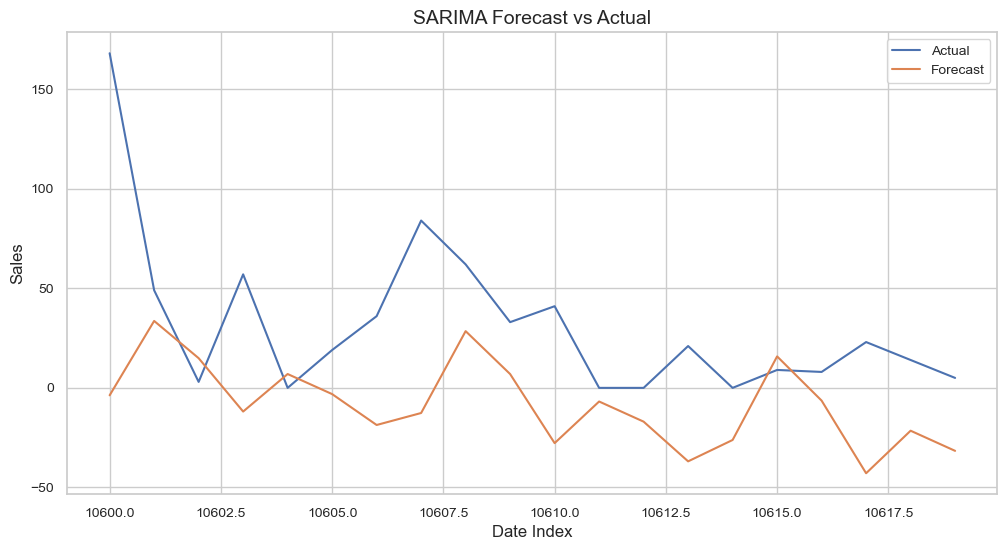

In [46]:
def plot_model_comparison(df):
    plt.figure()
    sns.barplot(data=df, x='Model', y='MAPE')
    plt.title('MAPE Comparison by Model')
    plt.ylabel('MAPE')
    plt.show()

plot_model_comparison(results_df)

def plot_final_forecast(best_model, X_valid, y_valid):
    preds = best_model['Estimator'].forecast(steps=len(y_valid), exog=X_valid[['sell_price']]) if 'ARIMAX' in best_model['Model'] else \
            best_model['Estimator'].forecast(steps=len(y_valid)) if 'ARIMA' in best_model['Model'] else \
            best_model['Estimator'].predict(X_valid)

    plt.figure()
    plt.plot(y_valid.index, y_valid.values, label='Actual')
    plt.plot(y_valid.index, preds, label='Forecast')
    plt.title(f"{best_model['Model']} Forecast vs Actual")
    plt.xlabel("Date Index")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

plot_final_forecast(best_model, X_valid, y_valid)

## Deployment and Execution Guide

In [28]:
# To apply the selected model to a new dataset:
# 1. Ensure feature structure matches training data
# 2. For ARIMAX, provide exogenous variables
# 3. Use: model.forecast(steps=n, exog=new_X) or model.predict(new_X)